# Exploratory Data Analysis for Trading at Close


#### - The d is available at kaggle for competitione https://www.kaggle.com/competitions/optiver-trading-at-the-close/dataam.


# WhTrading at CloseenaStock exchanges are fast-paced, high-stakes environments where every second counts. The intensity escalates as the trading day approaches its end, peaking in the critical final ten minutes. These moments, often characterised by heightened volatility and rapid price fluctuations, play a pivotal role in shaping the global economic narrative for the day.

Each trading day on the Nasdaq Stock Exchange concludes with the Nasdaq Closing Cross auction. This process establishes the official closing prices for securities listed on the exchange. These closing prices serve as key indicators for investors, analysts and other market participants in evaluating the performance of individual securities and the market as a whole.

Within this complex financial landscape operates Optiver, a leading global electronic market maker. Fueled by technological innovation, Optiver trades a vast array of financial instruments, such as derivatives, cash equities, ETFs, bonds, and foreign currencies, offering competitive, two-sided prices for thousands of these instruments on major exchanges worldwide.

In the last ten minutes of the Nasdaq exchange trading session, market makers like Optiver merge traditional order book data with auction book data. This ability to consolidate information from both sources is critical for providing the best prices to all market participants.future health.

# Data Definitions 

Files
[train/test].csv The auction data. The test data will be delivered by the API.

stock_id - A unique identifier for the stock. Not all stock IDs exist in every time bucket.
date_id - A unique identifier for the date. Date IDs are sequential & consistent across all stocks.
imbalance_size - The amount unmatched at the current reference price (in USD).
imbalance_buy_sell_flag - An indicator reflecting the direction of auction imbalance.
buy-side imbalance; 1
sell-side imbalance; -1
no imbalance; 0
reference_price - The price at which paired shares are maximized, the imbalance is minimized and the distance from the bid-ask midpoint is minimized, in that order. Can also be thought of as being equal to the near price bounded between the best bid and ask price.
matched_size - The amount that can be matched at the current reference price (in USD).
far_price - The crossing price that will maximize the number of shares matched based on auction interest only. This calculation excludes continuous market orders.
near_price - The crossing price that will maximize the number of shares matched based auction and continuous market orders.
[bid/ask]_price - Price of the most competitive buy/sell level in the non-auction book.
[bid/ask]_size - The dollar notional amount on the most competitive buy/sell level in the non-auction book.
wap - The weighted average price in the non-auction book.
BidPrice∗AskSize+AskPrice∗BidSizeBidSize+AskSize
seconds_in_bucket - The number of seconds elapsed since the beginning of the day's closing auction, always starting from 0.
target - The 60 second future move in the wap of the stock, less the 60 second future move of the synthetic index. Only provided for the train set.
The synthetic index is a custom weighted index of Nasdaq-listed stocks constructed by Optiver for this competition.
The unit of the target is basis points, which is a common unit of measurement in financial markets. A 1 basis point price move is equivalent to a 0.01% price move.
Where t is the time at the current observation, we can define the target:
Target=(StockWAPt+60StockWAPt−IndexWAPt+60IndexWAPt)∗10000
All size related columns are in USD terms.

All price related columns are converted to a price move relative to the stock wap (weighted average price) at the beginning of the auction period.

sample_submission A valid sample submission, delivered by the API. See this notebook for a very simple example of how to use the sample submission.

revealed_targets When the first time_id for each date (i.e. when seconds_in_bucket equals zero) the API will serve a dataframe providing the true target values for the entire previous date. All other rows contain null values for the columns of interest.

public_timeseries_testing_util.py An optional file intended to make it easier to run custom offline API tests. See the script's docstring for details. You will need to edit this file before using it.

example_test_files/ Data intended to illustrate how the API functions. Includes the same files and columns delivered by the API. The first three date ids are repeats of the last three date ids in the train set, to enable an illustration of how the API functions.

optiver2023/ Files that enable the API. Expect the API to deliver all rows in under five minutes and to reserve less than 0.5 GB of memory. The first three date ids delivered by the API are repeats of the last three date ids in the train set, to better illustrate how the API functions. You must make predictions for those dates in order to advance the API but those predictions are not scored.

# Standard Package imports

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.offline import init_notebook_mode
import seaborn as sns
import datetime as dt
from statsmodels.graphics.tsaplots import plot_acf
import warnings
import plotly.graph_objects as go
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier

import category_encoders as ce

In [70]:
tac_raw = pd.read_csv('TAC_Train.csv', sep = ',')
tac_test = pd.read_csv('TAC_Test.csv', sep = ',')

In [16]:
tac_raw.head()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.0,-3.029704,0.0,0_0_0
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.0,-5.519986,0.0,0_0_1
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.0,-8.389950,0.0,0_0_2
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.0,-4.010200,0.0,0_0_3
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.0,-7.349849,0.0,0_0_4


In [18]:
tac_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152721 entries, 0 to 152720
Data columns (total 17 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   stock_id                 152721 non-null  int64  
 1   date_id                  152721 non-null  int64  
 2   seconds_in_bucket        152721 non-null  int64  
 3   imbalance_size           152721 non-null  float64
 4   imbalance_buy_sell_flag  152721 non-null  int64  
 5   reference_price          152721 non-null  float64
 6   matched_size             152720 non-null  float64
 7   far_price                66082 non-null   float64
 8   near_price               67100 non-null   float64
 9   bid_price                152720 non-null  float64
 10  bid_size                 152720 non-null  float64
 11  ask_price                152720 non-null  float64
 12  ask_size                 152720 non-null  float64
 13  wap                      152720 non-null  float64
 14  targ

In [20]:
tac_raw.nunique()

stock_id                      192
date_id                        15
seconds_in_bucket              55
imbalance_size              76638
imbalance_buy_sell_flag         3
reference_price              9706
matched_size                81145
far_price                   13453
near_price                  13878
bid_price                    9392
bid_size                   134321
ask_price                    9454
ask_size                   134732
wap                         11033
target                       6700
time_id                       797
row_id                     152720
dtype: int64

In [22]:
for col in (tac_raw.columns):
    print(tac_raw[col].value_counts(), '\n')
    print(f"""total: {tac_raw[col].count()}  Null: {tac_raw[col].isnull().sum()}""", '\n')

0      797
70     797
83     797
82     797
81     797
      ... 
139    796
138    796
137    796
136    796
78     577
Name: stock_id, Length: 192, dtype: int64 

total: 152721  Null: 0 

4     10560
5     10560
6     10560
7     10560
8     10560
9     10560
10    10560
11    10560
12    10560
13    10560
0     10505
1     10505
2     10505
3     10505
14     5101
Name: date_id, dtype: int64 

total: 152721  Null: 0 

0      2876
140    2876
10     2876
250    2876
240    2876
230    2876
220    2876
210    2876
190    2876
180    2876
170    2876
160    2876
150    2876
200    2876
130    2876
70     2876
120    2876
30     2876
40     2876
50     2876
60     2876
20     2876
90     2876
100    2876
110    2876
80     2876
260    2793
410    2684
470    2684
430    2684
440    2684
450    2684
460    2684
500    2684
480    2684
490    2684
510    2684
520    2684
530    2684
420    2684
270    2684
400    2684
390    2684
380    2684
370    2684
360    2684
350    2684
340    2684

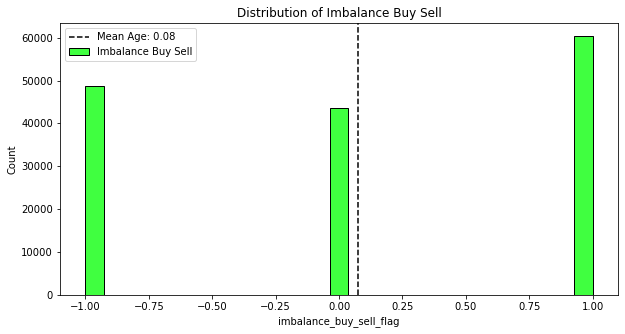

In [24]:
#Imbalance Buy Sell Distribution

plt.figure(figsize=(10,5))
sns.histplot(x=tac_raw['imbalance_buy_sell_flag'],color='Lime',label='Imbalance Buy Sell')
plt.axvline(x=tac_raw['imbalance_buy_sell_flag'].mean(),color='k',linestyle ="--",label='Mean Age: {}'.format(round(tac_raw['imbalance_buy_sell_flag'].mean(),2)))
plt.legend()

plt.title('Distribution of Imbalance Buy Sell')
plt.show()

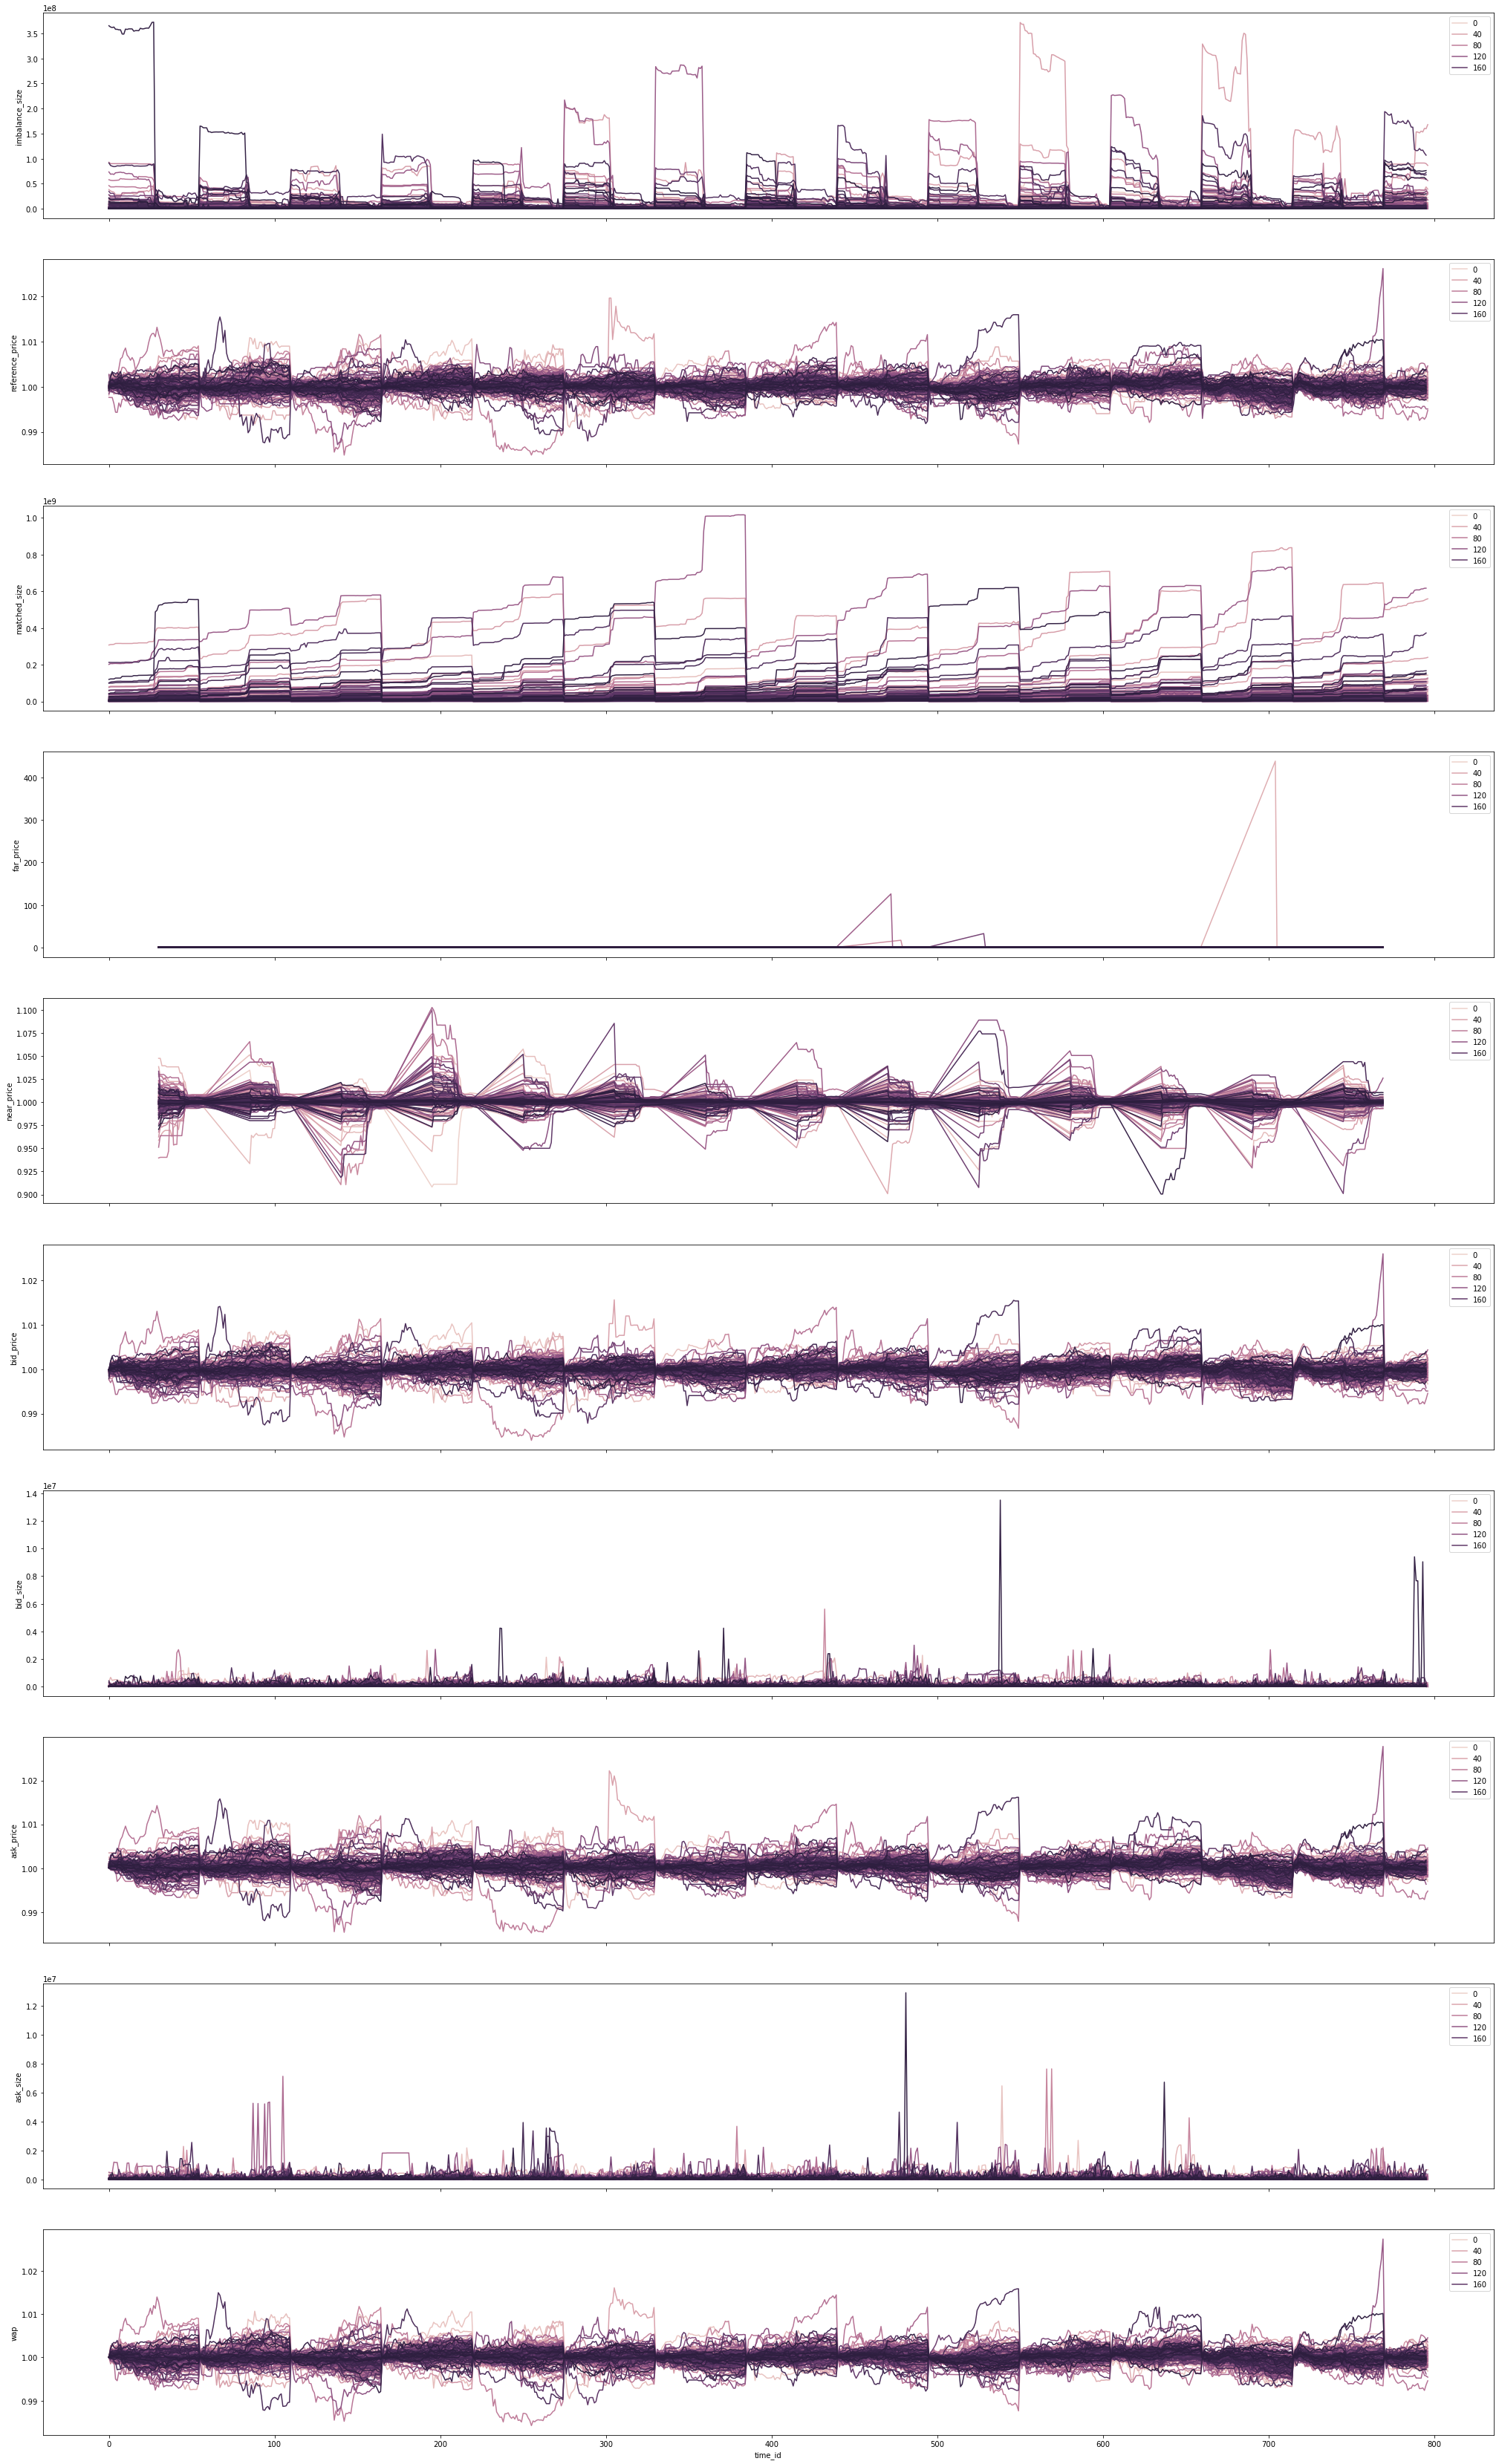

In [26]:
COLS = list(tac_raw.drop(['stock_id', 'date_id', 'seconds_in_bucket', 'target', 'row_id', 'imbalance_buy_sell_flag', 'time_id'], axis=1).columns)
fig, axes = plt.subplots(10, 1, sharex=True, figsize=(35,60))
for col, ax in zip(COLS, axes.ravel()):
    sns.lineplot(data=tac_raw, x='time_id', y=tac_raw[col], hue='stock_id', ax=ax)
    ax.legend(loc='best')       

<AxesSubplot:xlabel='target', ylabel='Count'>

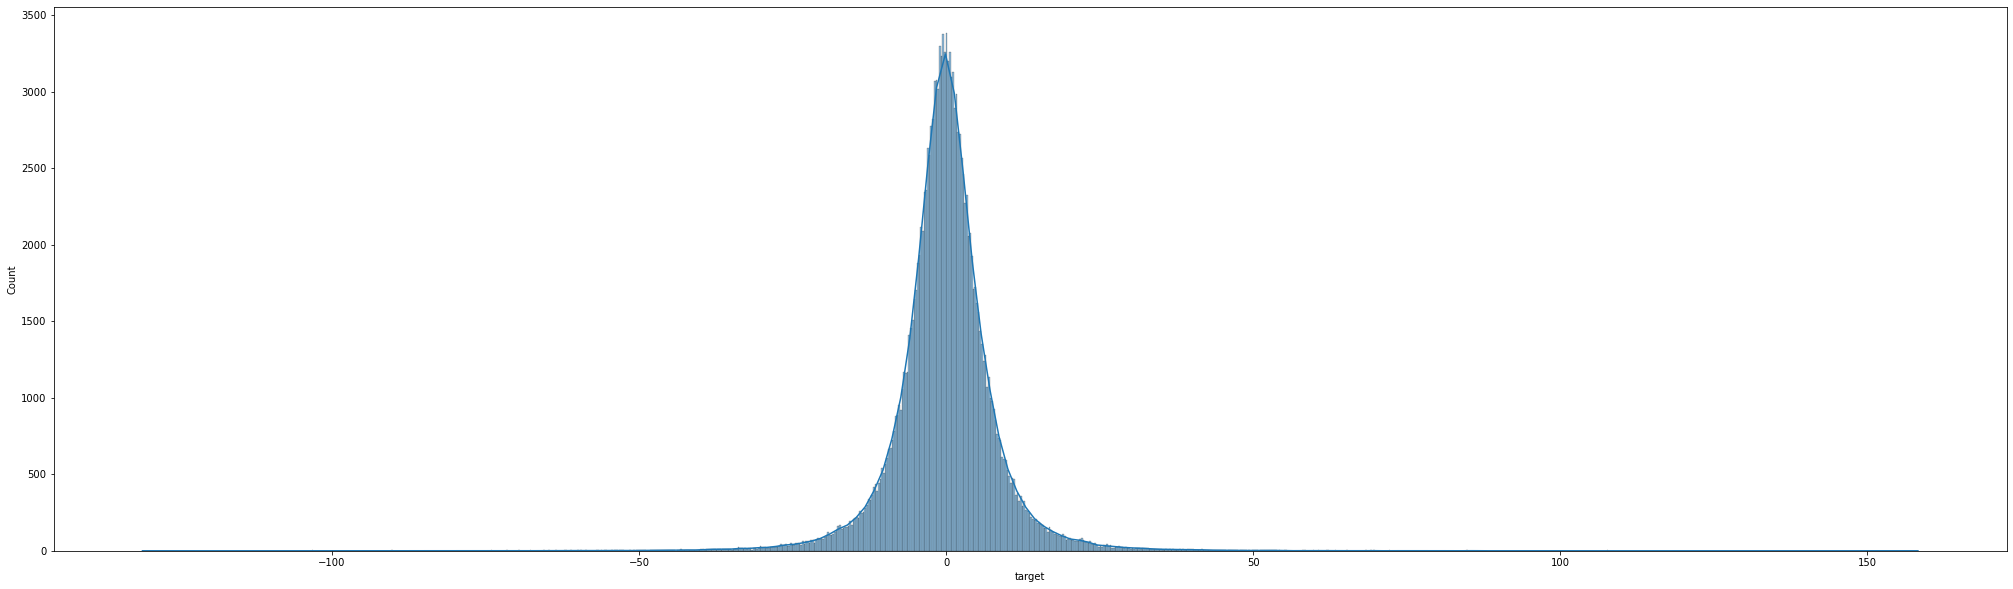

In [30]:
plt.figure(figsize=(35, 10))
sns.histplot(data=tac_raw, x='target', kde=True) 

# Based on below histplot we can see target mostly converges around closing 

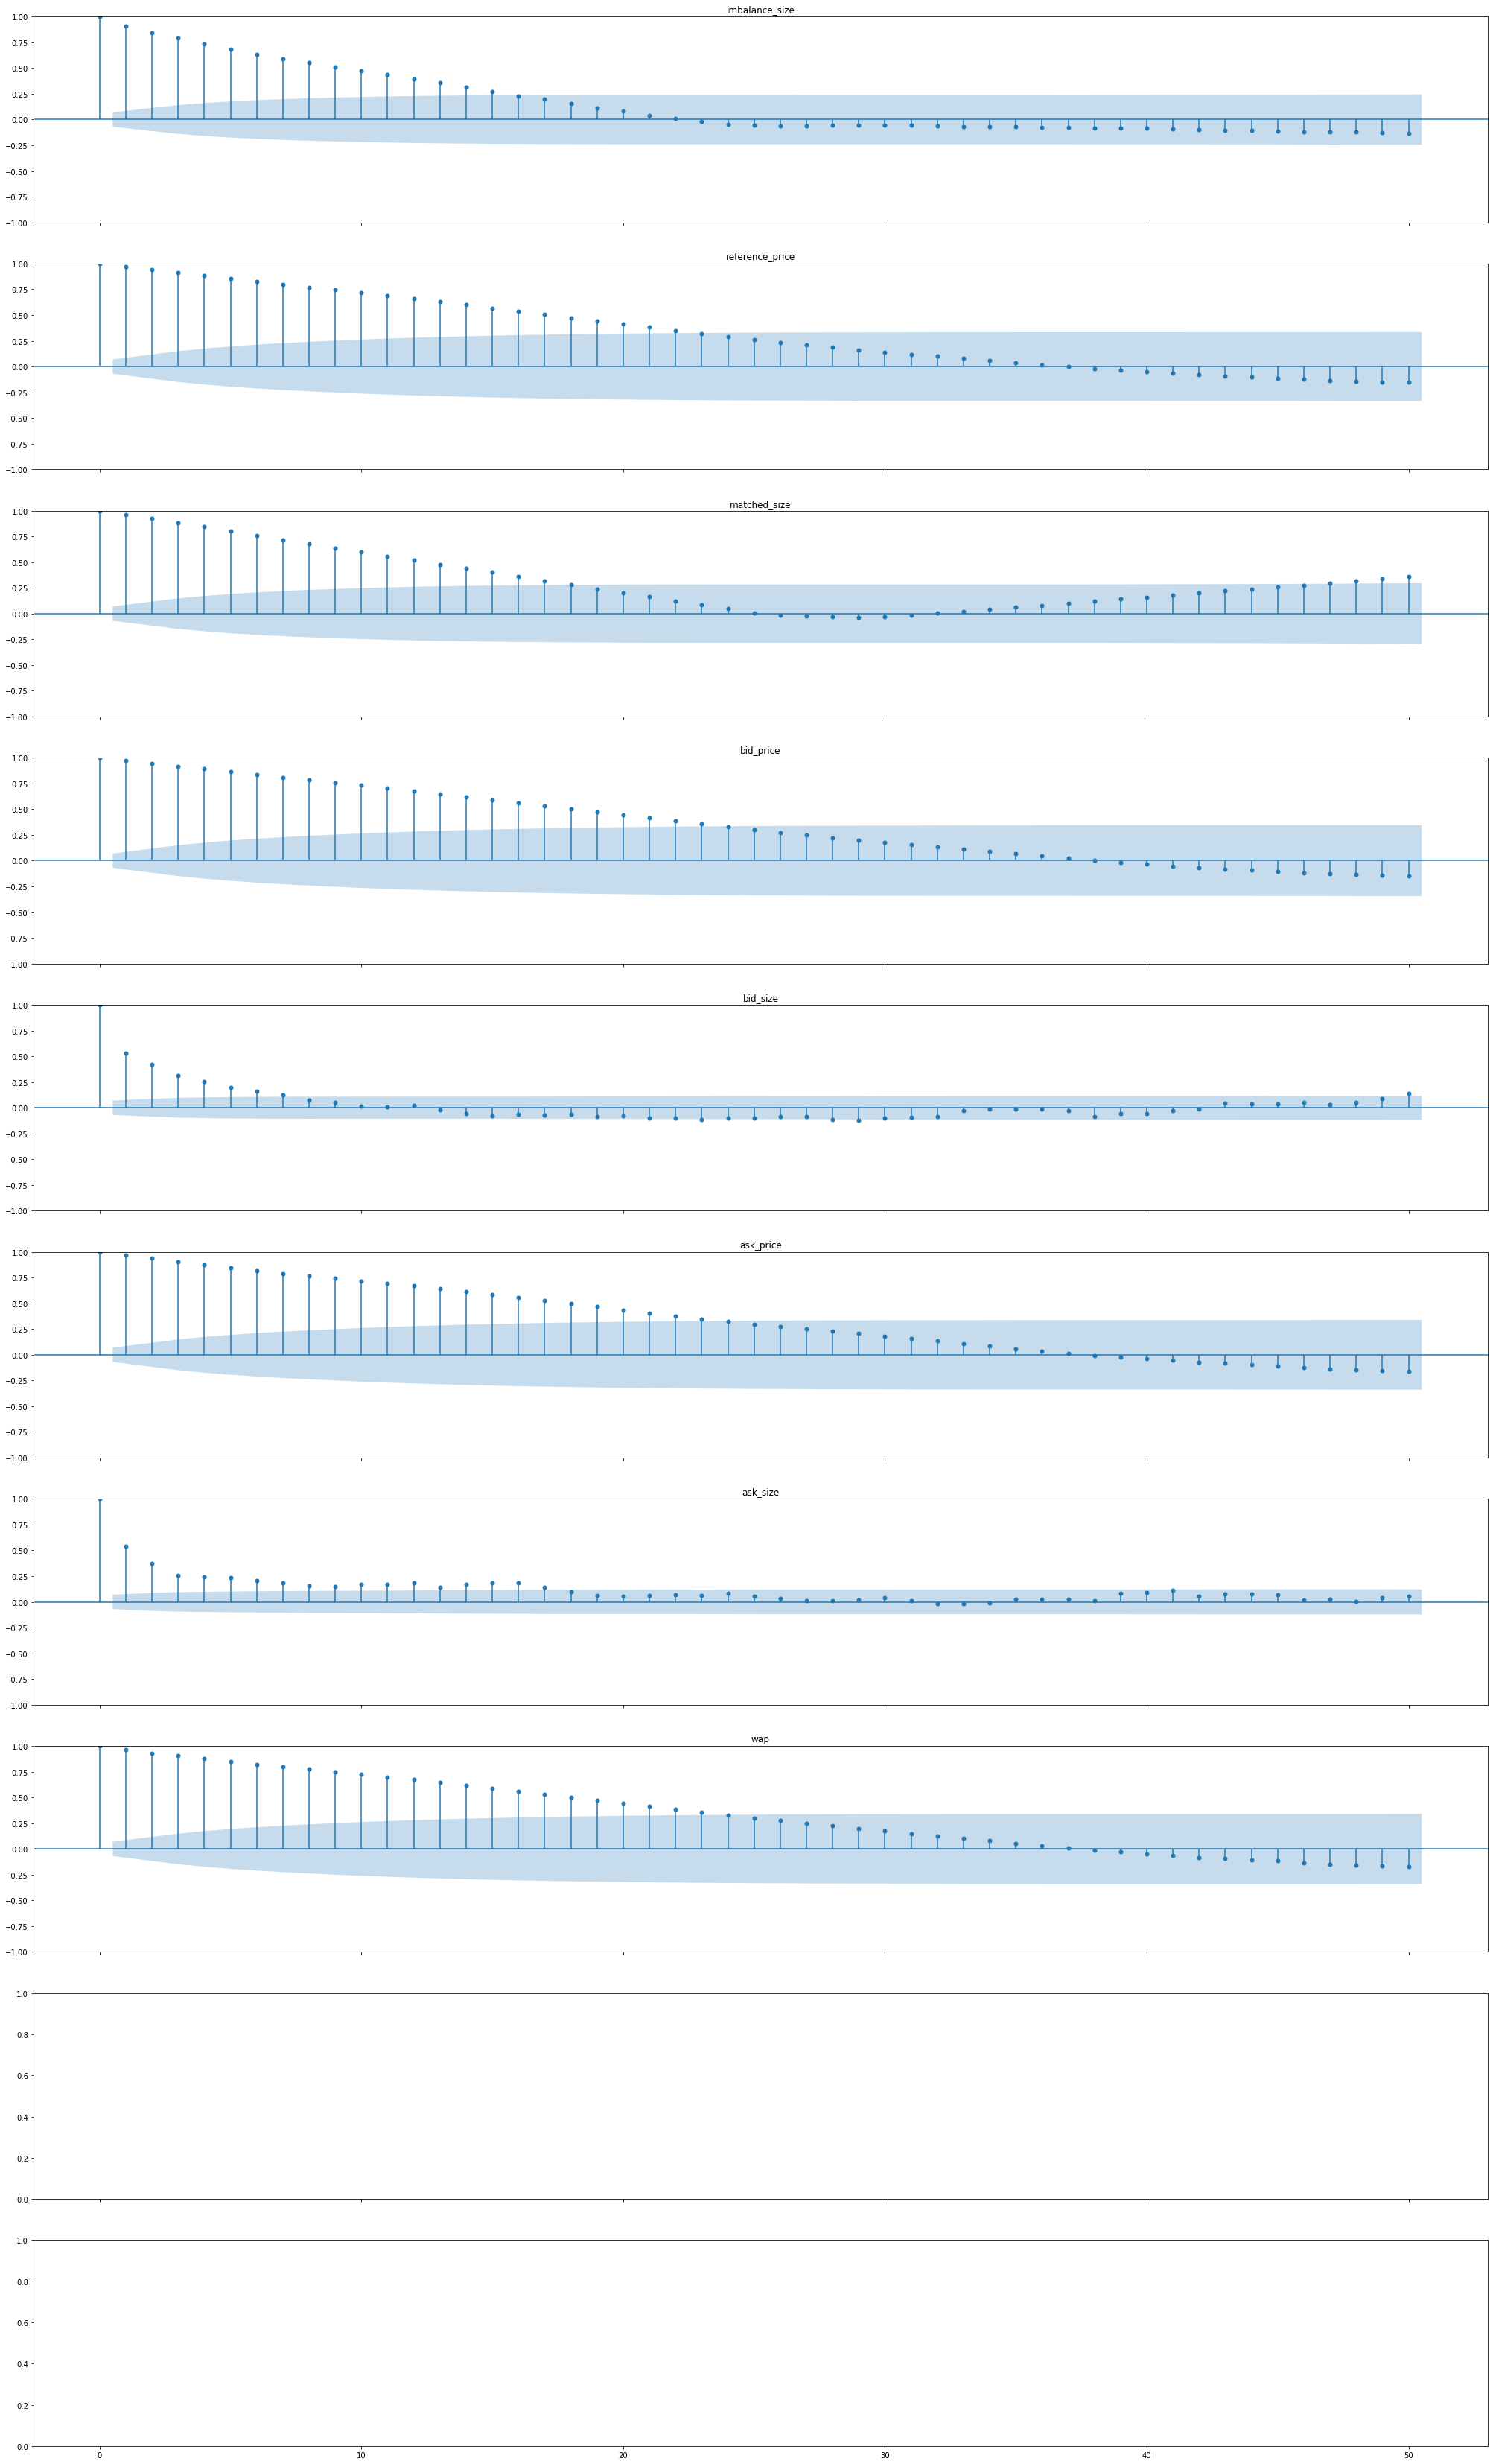

In [44]:
analysis_df = list(tac_raw.drop(['stock_id', 'date_id', 'seconds_in_bucket', 'target', 'row_id', 'imbalance_buy_sell_flag', 'time_id', 'near_price', 'far_price'], axis=1).columns)
fig, axes = plt.subplots(10, 1, sharex=True, figsize=(35,60))
for col, ax in zip(analysis_df, axes.ravel()):
    stock = tac_raw[tac_raw['stock_id']==1]
    plot_acf(stock[col][:500000], lags=50, ax=ax)
    ax.set_title(str(col))

#Below plots gives us trend of various attributes 

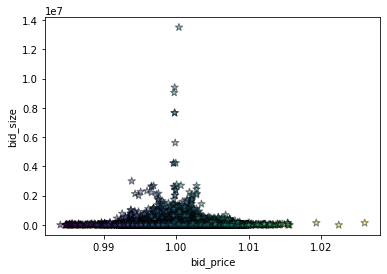

In [42]:
fig, ax = plt.subplots()
ax.scatter(tac_raw['bid_price'],tac_raw['bid_size'], marker='*',
          s=60, c=tac_raw['bid_price'], edgecolors='k',alpha=0.5)
ax.set_xlabel('bid_price')
ax.set_ylabel('bid_size');

## Based on below graph we can conclude that bid size increases mostly as demand when bid price is 1

<AxesSubplot:>

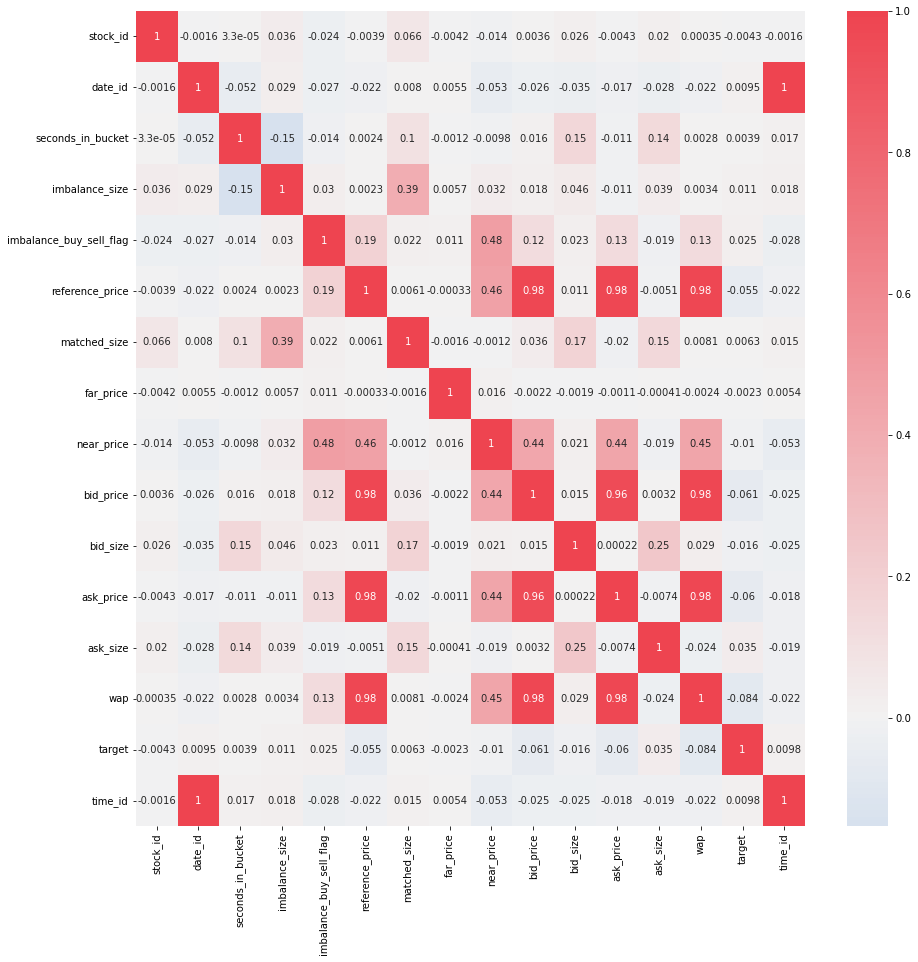

In [48]:
# Checking correlation matrix to see which parameters most affect target
corrmat= tac_raw.corr()
plt.figure(figsize=(15,15))  

cmap = sns.diverging_palette(250, 10, s=80, l=55, n=9, as_cmap=True)

sns.heatmap(corrmat,annot=True, cmap=cmap, center=0)

# Based on below we can say ['bid_price', 'ask_price', 'ask_size', 'wap'] has most greatest impact on target

# Data cleaning 

In [60]:
tac_clean = tac_raw.dropna()

# We will build decision tree regression model and time series as part of initial analysis 

In [74]:
# Feature extraction on training and test model 

y = tac_clean.target
features = ['bid_price', 'ask_price', 'ask_size', 'wap']
X = tac_clean[features]
X.head()
X_test = tac_test[features]

In [76]:
display('check the shape of train sets', X.shape, y.shape, X_test.shape)

'check the shape of train sets'

(66082, 4)

(66082,)

(33000, 4)

In [66]:
# BUilding a decision tree regressor model 
from sklearn.tree import DecisionTreeRegressor
model = DecisionTreeRegressor(random_state=1)

# Fit model
model.fit(X, y)

DecisionTreeRegressor(random_state=1)

In [78]:
print("Making predictions for 5 targets from test dataset:")
print(X_test.head())
print("The predictions are")
print(model.predict(X_test.head()))

Making predictions for 5 targets from test dataset:
   bid_price  ask_price  ask_size  wap
0   0.999875   1.000050   9177.60  1.0
1   0.999940   1.000601  19692.00  1.0
2   0.999918   1.000636  34955.12  1.0
3   0.999705   1.000189  10314.00  1.0
4   0.999720   1.000107   7245.60  1.0
The predictions are
[10.4904175 14.669895   8.690357  -4.5502186  2.8395653]


# Scoring the model 

We will score the model based on mean absolute error on train dataset

In [80]:
from sklearn.metrics import mean_absolute_error
predicted_targets = model.predict(X)
mean_absolute_error(y, predicted_targets)

2.7242821423117167e-02

In [ ]:
Next i will do more refinements with creating different models and comparing them and ding more feature extractions